In [6]:
import aprofiles as apro

In [8]:
path = "data/e-profile/2021/09/08/L2_0-20000-006735_A20210908.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

altitude = profiles.data.altitude.data
wavelength = profiles.data.l0_wavelength.data

In [26]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [254]:
from scipy.interpolate import interp1d
import math
import matplotlib.pyplot as plt

#standard values at sea level
T0 = 298
P0 = 1013
        
#standart gradients & parameters
atmo = {
    'tropo': {
        'zmin': 0,
        'zmax': 13,
        'dTdz': -6.5
    },
    'strato': {
        'zmin': 13,
        'zmax': 55,
        'dTdz': 1.4
    },
    'meso': {
        'zmin': 55,
        'zmax': 100,
        'dTdz': -2.4
    }
}

p_He = 8;

#convert pressure from hPa to Pa
p_z0 = P0*100;
#convert altitude to km
z = altitude/1000;

#vertical resolution
dz = min(z[1:]-z[0:-1])

#temperature profile
Tz = [T0]
for layer in atmo.keys():
    ibottom = int(np.floor(atmo[layer]['zmin']/dz))
    itop = int(np.floor(atmo[layer]['zmax']/dz))
    for i in range(ibottom,itop):
        Tz.append(Tz[ibottom]+(i-ibottom)*atmo[layer]['dTdz']*dz)

#vertical coordinates for temperature
z_Tz = np.arange(0,100,dz)

#pressure profile
Pz=p_z0*np.exp(-z_Tz/p_He);

#Number of molecules
N_m=np.divide(Pz,(8.314/np.multiply(6.023e23,Tz)));
#molecular section
section_m=5.45*np.power(550/wavelength,4.09)*1e-32;

#backscatter profile
bmol=N_m*section_m;
#extinction profile
amol=8.0*math.pi*bmol/3.0;

#colocate vertically to input altitude
imin = np.argmin(np.abs(np.array(z_Tz)-z[0]))
imax = imin+len(z)

self_t = Tz[imin:imax]
self_p = Pz[imin:imax]
self_bmol = bmol[imin:imax]
self_amol = amol[imin:imax]

In [256]:
temperature = self_t
pressure = self_p
backscatter = self_bmol
extinction = self_amol

In [277]:
import xarray as xr
#creates dataset
ds = xr.Dataset(
    data_vars=dict(
        temperature=(["altitude"], temperature,{'units': 'K','long_name': 'standard temperature'}),
        pressure=(["altitude"], pressure,{'units': 'Pa','long_name': 'standard pressure'}),
        backscatter=(["altitude"], backscatter,{'units': 'km-1.sr-1','long_name': 'rayleigh backscater at {} nm in a standard atmosphere'.format(wavelength)}),
        extinction=(["altitude"], extinction,{'units': 'km-1','long_name': 'rayleigh extinction at {} nm in a standard atmosphere'.format(wavelength)})
    ),
    coords=dict(
        altitude=altitude,
    ),
    attrs=dict(description="Standard Rayleigh Profile."),
)

In [278]:
ds.backscatter

<xarray.DataArray 'backscatter' (altitude: 257)>
array([0.01247 , 0.012415, 0.01236 , ..., 0.003988, 0.00397 , 0.003952])
Coordinates:
  * altitude  (altitude) float64 1.337e+03 1.367e+03 ... 8.986e+03 9.016e+03
Attributes:
    units:      Mm-1.sr-1
    long_name:  rayleigh backscater at 910.0 nm in a standard atmosphere

In [228]:
z_Tz[1]-z_Tz[0]

0.0008999528271136556

In [223]:
z[1]-z[0]

0.029995427727699253

array([0.00000000e+00, 2.99954277e-02, 5.99908555e-02, ...,
       9.99147698e+01, 9.99447652e+01, 9.99747606e+01])

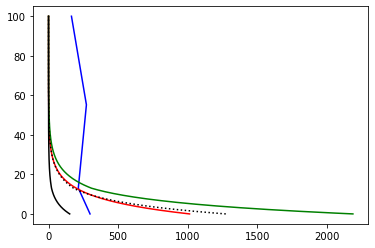

In [232]:
plt.plot(Tz,z_Tz,'b')
plt.plot(Pz/100,z_Tz,'r')
plt.plot(N_m*1e-27,z_Tz,'g')

plt.plot(bmol*1e4,z_Tz,'k')
plt.plot(amol*1e4,z_Tz,'k:')

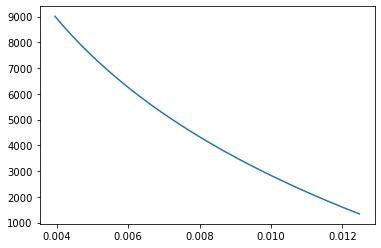

In [237]:
plt.plot(self_bmol,altitude)

In [195]:
np.argmin(10-[0,5,10,15,20])

TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [200]:
np.argmin(np.abs(np.array([0,5,10,15,20])-10))

2